# Задание 7

Обучить нейронную сеть для распознавания действий человека по видео на датасете KTH
Библиотеки: [Python, Tensorflow]


## Переключение версии TensorFlow

In [1]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [1]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import math

import tensorflow as tf

In [2]:
if 0:
    !pip install scikit-video==1.1.11
import skvideo.io

## Загрузка и распаковка датасета

Датасет KTH - набор видеофайлов в формате avi: прогулка, пробежка, бег, боксинг, махание руками, хлопанье руками,

In [3]:
if 1:
      !wget http://www.csc.kth.se/cvap/actions/walking.zip
      !wget http://www.csc.kth.se/cvap/actions/jogging.zip
      !wget http://www.csc.kth.se/cvap/actions/running.zip
      !wget http://www.csc.kth.se/cvap/actions/boxing.zip
      !wget http://www.csc.kth.se/cvap/actions/handwaving.zip
      !wget http://www.csc.kth.se/cvap/actions/handclapping.zip

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [8]:
if 1:
  !unzip walking.zip -d walking > /dev/null
  !unzip jogging.zip -d jogging > /dev/null
  !unzip running.zip -d running > /dev/null
  !unzip boxing.zip -d boxing > /dev/null
  !unzip handwaving.zip -d handwaving > /dev/null
  !unzip handclapping.zip -d handclapping > /dev/null

## Подготовка датасета для классификации

In [9]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]


# Создаём датасет, каждый элемент которого содержит путь к файлу и номер класса
dataset = []
data_root = './'  # Путь откуда берём файлы

for cls in classes:
    print(f'Processing class: {cls} - {len(os.listdir(cls))} samples')
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):  # Получаем путь к avi-файлам
        cls_idx = classes.index(cls)  # Индекс класса
        dataset.append((fpath, cls_idx))

Processing class: walking - 100 samples
Processing class: jogging - 100 samples
Processing class: running - 100 samples
Processing class: boxing - 100 samples
Processing class: handwaving - 100 samples
Processing class: handclapping - 99 samples


In [10]:
len(dataset)

599

In [11]:
dataset[:5]

[('./walking/person10_walking_d2_uncomp.avi', 0),
 ('./walking/person23_walking_d4_uncomp.avi', 0),
 ('./walking/person17_walking_d1_uncomp.avi', 0),
 ('./walking/person05_walking_d4_uncomp.avi', 0),
 ('./walking/person14_walking_d1_uncomp.avi', 0)]

файл, класс

In [12]:
type(dataset[0])

tuple

## Разделение на тренировочную и тестовую выборки.

In [13]:
random.shuffle(dataset)

test_count = math.floor(len(dataset)*0.4)

train_ds = dataset[:-test_count]
test_ds = dataset[-test_count:]

In [14]:
len(train_ds), len(test_ds)

(360, 239)

## Визуализация кадра из видео

videodata shape: (510, 120, 160, 3)
videodata shape: (120, 160, 3)


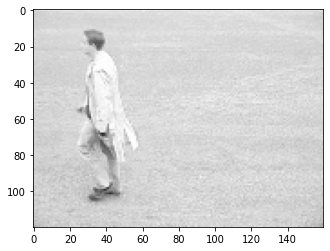

In [16]:
# import skvideo.io

# Прочитаем наши данные. dataset[0][0] - путь к файлу.
videodata = skvideo.io.vread(dataset[0][0])
videodata = videodata.astype(np.float32) / 255.  # Приводим тензор к диапазону [0, 1]
                                                 # Изначально были значения int8 [0, 255]

# 3d-тензор первые измерения это кадр
print('videodata shape:', videodata.shape)
print('videodata shape:', videodata[50, ...].shape)
plt.imshow(videodata[50, ...]) # берем 50-й кадр.
plt.show()

# videodata shape: (477, 120, 160, 3)
# 3d-тензор (3d массив, где по одному измерению идут кадры)
# 477 - количество кадров
# 120, 160 - пространственные координаты
# 3 - количество каналов (3 несмотря на то, что видео чёрно-белое)

## Свертка движения

Предобработка.
Получаем движение пикселей. Например: из 3-го кадра вычитаем 2-й попиксельно, получаем движение в пиксельном пространстве.<br>
Это не движение, а как поменялись цвета вследствии движения.


motion shape: (509, 120, 160, 1)


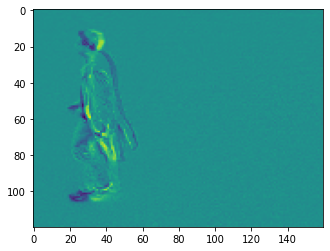

In [17]:
# Срез первого тензора, с 1-го кадра. 0-й не используем.
# Вычетаем из него тензор. Берём наоборот с 0-го по предпоследний. Не включая последний кадр.
# Получаем набор разностей: 1-0, 2-1, 3-2, ... .
# Сразу усредняем по 3-му измерению, т. к. у нас градация серого.
# keepdims=True - 3-е измерение превращается в 1 (вместо 3 бедет 1).
# Если keepdims=False - 3-е измерение исчезнет.
motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
print('motion shape:', motion.shape)
plt.imshow(motion[50, ..., 0])

# motion - тоже видеозапись, где на каждом кадре содержится движение
# Получаем в итоге тензор размерности (476, 120, 160, 1)
# 476 было 477
# 1 - цвета сократили до одного цвета.

## Класс генерации Dataset

> **tf.keras.utils.Sequence** Base object for fitting to a sequence of data, such as a dataset. [Sequence](https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence)

In [18]:
from tensorflow.keras.utils import Sequence

class KTHDataset(Sequence):
    # Подготовка датасета

    def __init__(self, data, max_frames, shuffle=False, batch_size=1, motion=True):
        """
        Конструктор

        Параметры:
        data - выборка [(path, label), ...]
        max_frames - количество кадров в видеоряде.
                     Чтобы видеоролики можно было объединить в batch,
                     к-во кадров у них должно быть одинаковым.
        shuffle - перемешать образцы.
        batch_size - размер batch-a.

        """
        self.data = data
        self.data_indices = list(range(len(data)))
        self.max_frames = max_frames
        self.shuffle = shuffle
        self.batch_size = batch_size
        if shuffle:
            random.shuffle(self.data_indices)

    def _get_videodata(self, path, motion=True):
        # Читаем данные
        videodata = skvideo.io.vread(path)
        videodata = videodata.astype(np.float32) / 255.

        # Количество повторений до необходимого размера
        n_repeats = (self.max_frames + 1) // videodata.shape[0]
        # Номер последнего кадра
        last_frame = (self.max_frames + 1) - (videodata.shape[0] * n_repeats)

        # приведение массивов к форме (max_frames, height, width, n_channels)
        # видео с меньшим кол-вом кадров - повторяется до необходимого размера
        # видео с большим - обрезается
        videodata = np.append(
            np.repeat(videodata, n_repeats, axis=0),  # Копировати n_repeats раз
            videodata[:last_frame],   # добавляемые значения
            axis=0
        )

        # "движение"
        if motion:
            videodata = np.mean(
                videodata[1:, ...] - videodata[:-1, ...], 
                axis=3, 
                keepdims=True
            )
        return videodata

    def __getitem__(self, idx, motion=True):
        # Поведение при обращении к объекту
        batch_indices = self.data_indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X = []
        batch_y = []
        for i in batch_indices:
            path, label = self.data[i]
            videodata = self._get_videodata(path, motion)
            batch_X.append(videodata)
            batch_y.append(label)
        return np.array(batch_X), np.array(batch_y)

    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

In [19]:
import math

videodata_shape = 572
max_frames = 4000
batch_size = 400
n_repeats = (max_frames + 1)//videodata_shape
print(videodata_shape, max_frames, n_repeats, (max_frames+1) - videodata_shape*n_repeats)
print(math.ceil(videodata_shape / batch_size), videodata_shape / batch_size)
# 392 400 1 9
# 572 400 0 401
# 572 4000 6 569

572 4000 6 569
2 1.43


## Генерация выборок

In [20]:
train = KTHDataset(train_ds, max_frames=400, shuffle=True, batch_size=4)
test = KTHDataset(test_ds, max_frames=400, shuffle=False, batch_size=4)

walking


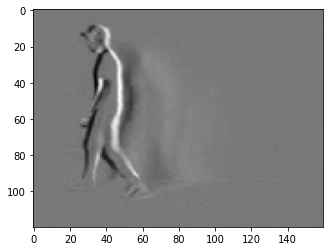

In [21]:
idx = np.random.randint(len(train))

batch_X, batch_y = train[idx]

# plt.imshow(batch_X[0][-200, ..., 0], cmap='gray')
plt.imshow(batch_X[0][-200, ..., 0], cmap='gray')
print(classes[batch_y[0]])
plt.show()

In [22]:
test_without_motion = KTHDataset(test_ds, max_frames=400, shuffle=False, batch_size=1, motion=False)

handwaving


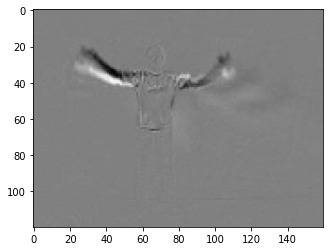

In [23]:
idx = np.random.randint(len(train))

batch_X, batch_y = train[idx]

plt.imshow(batch_X[0][-200, ..., 0], cmap='gray')
print(classes[batch_y[0]])
plt.show()

## Создание модели CNN

In [25]:
# Используем 3d-свёртки
# (5, 5, 5) = 5x(5x5) в окно попадает 5 кадров и пространственный кусочек 5x5
# Этим окном пробегаемся по всему 3d массиву
# (1, 2, 2) - страйд. 1 - не уменьшаем разрешение по временному измерению.
# 2, 2 - понижаем пространственное разрешение в 2 раза
model = tf.keras.Sequential([  
    # на выходе 32 канала, ядро 
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    # 3d-pooling
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),  
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    
    # GlobalAveragePooling3D - все карты признаков агрегирует в одно число!
    # GlobalAveragePooling3D - делает усреднение (reduce)
    # по пространственным и временным измерениям (см. ниже)
    # Получится 64 числа (64d-вектор).
    tf.keras.layers.GlobalAveragePooling3D(),
    
    tf.keras.layers.Dense(64, activation='relu'),

    # tf.keras.layers.Dropout(0.5),  # Добавляем Dropout
    
    tf.keras.layers.Dense(6, activation=None),
])

## Подготовка к обучению

In [27]:
NUM_EPOCHS = 3
LEARNING_RATE = 0.001  # 5e-4

# SparseCategoricalCrossentropy - разреженная категориальная кроссэнтропия
# from_logits=True - так как мы не поставили функцию активации softmax,
# loss сам должен накрутить softmax сверху
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    # loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))

# Используем tenzorbord и пишем summary в дирректорию 'logs/exp1'
writer = tf.summary.create_file_writer('logs/model')

# Не указываем размер batch-а так как он равен 1.
# Так как у нас простая имплементация.

In [29]:
checkpoint_filepath = './models/checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

## Цикл обучения модели

In [30]:
model.fit(train, validation_data=test, epochs=NUM_EPOCHS, callbacks=[model_checkpoint_callback])

Epoch 1/3
90/90 [==============================] - 415s 5s/step - loss: 1.7396 - val_loss: 1.5069
Epoch 2/3
90/90 [==============================] - 407s 5s/step - loss: 1.1384 - val_loss: 1.1218
Epoch 3/3
90/90 [==============================] - 408s 5s/step - loss: 0.9028 - val_loss: 0.9377


In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, None, None, None,  4032      
                              32)                                
                                                                 
 max_pooling3d (MaxPooling3D  (None, None, None, None,  0        
 )                            32)                                
                                                                 
 conv3d_1 (Conv3D)           (None, None, None, None,  256064    
                              64)                                
                                                                 
 max_pooling3d_1 (MaxPooling  (None, None, None, None,  0        
 3D)                          64)                                
                                                                 
 conv3d_2 (Conv3D)           (None, None, None, None,  1

## Тестирование обученной модели

True class: handwaving
Predicted class: handwaving


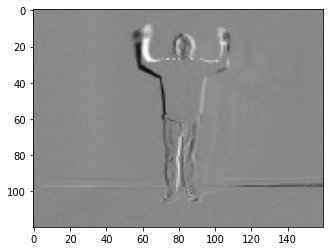

In [34]:
idx = np.random.randint(len(test))

batch_X, batch_y = test[idx]

plt.imshow(batch_X[0][200, ..., 0], cmap='gray')

out = model(batch_X)[0]
cls_pred = np.argmax(out.numpy())

print('True class:', classes[batch_y[0]])
print('Predicted class:', classes[cls_pred])
plt.show()

True class: handclapping
Predicted class: handclapping


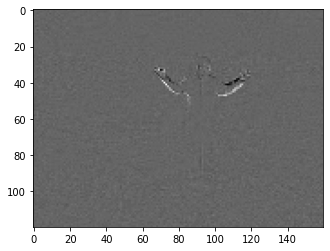

In [35]:
idx = np.random.randint(len(test))

batch_X, batch_y = test[idx]

plt.imshow(batch_X[0][200, ..., 0], cmap='gray')

out = model(batch_X)[0]
cls_pred = np.argmax(out.numpy())

print('True class:', classes[batch_y[0]])
print('Predicted class:', classes[cls_pred])
plt.show()

## Выводы

Процесс был изменен  и оказался более эффективным. Провел разделение на тестовую и тренировочную выборку. Сделан класс для обработки данных.




В качестве идей:

1. Ввести детекцию движений и не включать статичные кадры (с порогом ) в обучение.
2. При инференсе тоже использовать фильтрацию движений.
3. Использовать просеивание кадров по порогу не включать мелкие изменения.
4. Использовать кроп по среднему окну захвата движения.